In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cv2
import itertools
from IPython.display import HTML
%matplotlib notebook

# Elementos del problema


* Suponemos que tenemos un **robot** que podemos representar como un **polígono convexo** definido sobre un punto que se utilizará como marco de referencia: $\mathcal{R}(x,y)$.
* Los movimientos del robot se limitan a **desplazamientos** (traslaciones) y rotaciones en un plano bidimensional.
* En el plano, se encuentran distribuidos una serie de **obstáculos** físicos los cuales no pueden ser atravesados por el robot: $\mathcal{P} = \{P_1, P_2, P_3, \ldots, P_n\}$.
* El **objetivo** es desplazar al robot, sobre el plano, hasta un punto fijo **sin colisionar** con los obstáculos.


# Funciones para las gráficas

In [2]:
# Definir Colores
black, red, green, blue, white = ((0,0,0),(255,0,0),(0,255,0),(0,0,255),(255,255,255)) 
cgoal, Path = ((15,150,0), (81,209,246))
# Despliega una imagen
def Plot(image):
    #plt.title('Navegacion Robotica')
    plt.imshow(image,cmap="gray")
    plt.axis("off")
    plt.show()
# Dibuja el camino encontrado
def Draw_Path(image, path):
    imc = image.copy()
    for (x,y) in path:
        cv2.rectangle(imc, (x,y), (x,y), Path, -1) 
    Plot(imc)

# Problema principal

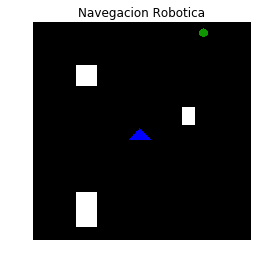

In [3]:
def mainproblem():
    image = np.zeros((512,512,3), np.uint8)

    #dibuja una serie de obstáculos
    cv2.rectangle(image, (100,100), (150,150), (255,255,255), -1)
    cv2.rectangle(image, (350,200), (380,240), (255,255,255), -1)
    cv2.rectangle(image, (100,400), (150,480), (255,255,255), -1)

    #ubicación del robot
    [x,y] = [250, 250]
    pts = np.array( [[x,y], [x-25,y+25], [x+25,y+25]], np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.fillPoly(image, [pts], (0,0,255))

    #objetivo
    cv2.circle(image, (400, 25), 10, (15,150,0), -1)
    return image
image = mainproblem()
plt.title('Navegacion Robotica')
Plot(image)

# Detección de elementos (Robot y Meta)

In [4]:
# Crea una cola con los pixeles de cierto color dado
def Pixel_queue(image, color):
    queue = []
    for (y,row) in enumerate(image):
        for (x,value) in enumerate(row):
            if (tuple(value) == color):
                queue.append((x,y))
    return queue

# Calcula el Centro de Gravedad del Robot y el radio de la circuferencia
def Robot_Gravity_Center(image):
    dt = np.dtype([('x',int), ('y', int)])
    recarray = np.array(Pixel_queue(image, blue), dtype=dt )
    sortx = list(np.sort(recarray, order='x'))
    sorty = list(np.sort(recarray, order='y'))
    pts = np.array([list(sorty[0]), list(sortx[0]), list(sortx[-1])], dtype=np.int32)
    # Centro de gravedad del poligono
    (cx, cy) = (int(pts[:,0].mean()), int(pts[:,1].mean()))
    radius = []
    for (x,y) in pts:
        radius.append(int(np.sqrt((x-cx)**2 + (y-cy)**2)))
    # No quedamos con el mayor valor de radio
    r = max(radius)
    return ((cx,cy), r)

# Calcula el Centro de Gravedad de la meta y el radio de la circuferencia
def Goal_Gravity_Center(image):
    dt = np.dtype([('x',int), ('y', int)])
    pixel = np.sort(np.array(Pixel_queue(image, cgoal), dtype=dt), order='y')
    pt1 = pixel[0]
    pt2 = pixel[-1]
    pt = ((pt1['x']+pt2['x'])/2, (pt1['y']+pt2['y'])/2)
    r = int(np.sqrt((pt1['x']-pt[0])**2 + (pt1['y']-pt[1])**2))
    return (pt, r)

# Funciones de Distance Transform

In [5]:
# Invierte la imagen binaria reconociendo unicamente los obstaculos sobre el grid
def Detect_Solids(image):
    invbin = np.zeros((image.shape[:2]), np.uint8)
    for (i,row) in enumerate(image):
        for (j,value) in enumerate(row):
            invbin[i][j] = (0) if (tuple(value) == white) else (10**3)
    return invbin

# Invierte la imagen binaria reconociendo el objetivo de la navegación
def Detect_Goal(image):
    invbin = np.zeros((image.shape[:2]), np.uint8)
    for (i,row) in enumerate(image):
        for (j,value) in enumerate(row):
            invbin[i][j] = (0) if (tuple(value) == Goals) else (10**3)
    return invbin

# Aplica Transformación Distancia con la librería OpenCV
def Distance_Transform(image, solids=True):
    if solids:
        distance_transform = cv2.distanceTransform(Detect_Solids(image), cv2.DIST_LABEL_PIXEL, 3)
    else:
        distance_transform = cv2.distanceTransform(Detect_Goal(image), cv2.DIST_LABEL_PIXEL, 3)
    return distance_transform

# Simulador de la trayectoria a seguir

In [6]:
# Simula el recorrido del camino obtenido
def Path_Simulator(image, path):
    imc = image.copy()
    # Borra ubicación del robot
    imc[path[0][1]][path[0][0]] = black
    # Guarda la primera imagen en la lista
    gif = [image]
    for (x,y) in path[1:]:
        s = imc.copy()
        s[y][x]=blue
        gif.append(s)
    fig = plt.figure()
    plt.axis('off')
    # ims is a list of lists, each row is a list of artists to draw in the current frame; here we are just 
    # animating one artist, the image, in each frame
    ims = []
    for i in range(len(gif)):
        im = plt.imshow(gif[i], animated=True)
        ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=250, blit=True, repeat_delay=1000)
    return HTML(ani.to_jshtml())

# Algoritmo de búsqueda A*

In [7]:
# Funciones complementarias del A*

# Calcula la distancia heuristica de la posición actual al objetivo
def heuristic_cost_estimate(position, goal):
    # Manhattan Distance
    return abs(position[0]-goal[0]) + abs(position[1]-goal[1])

# Reconstruye en camino de la lista cerrada
def reconstruct_path(closedset, current):
    path = [current[0]]
    dt = np.dtype([('Node', tuple), ('Father', tuple)])
    recarray = np.array(closedset, dtype=dt)
    if closedset:
        api = recarray[list(recarray['Node']).index(current[1])] #
        while api['Node'] != api['Father']:
            path.append(api['Node'])
            api = recarray[list(recarray['Node']).index(api['Father'])]
    path.append(api['Node'])
    return path[::-1]

# Determina si las coordenadas actuales están dentro del rango de la imagen
def Image_Range(coor, shape):
    (cx, cy) = coor
    flag = np.logical_and([cx >= 0, cy >= 0], [cx < shape[1], cy < shape[0]])
    return np.logical_and(flag[0], flag[1])

# Determina las coordenadas vecinas a movernos sobre el grid de un determinado punto en la imagen
def Neighbors():
    # Valores que nos permiten navegar en el grid a los 8 vecinos más cercanos por medio 
    # del índice de las coordenadas alrededor del pixel actual
    # permuta = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
    permutations = [(-1,-1)]
    permutations.extend(list(itertools.permutations([-1, 0, 1], 2)))
    permutations.append((1,1))
    return permutations

# Evalua si las coordenadas actuales pertene a un sólido
def Solid(coor, image):
    (cx, cy) = coor
    return (tuple(image[cy][cx]) == white)

# Evalua si se puede realizar un movimiento diagonal sin intervenciones de sólidos cercanos
def Diagonal_Move(coor, neighbor, image):
    (cx, cy) = coor
    (x, y) = neighbor
    flag = np.logical_not(np.logical_or(Solid((cx, cy+y), image), Solid((cx+x, cy), image)))
    return flag

In [26]:
# Algoritmo de búsqueda A*
def A_Star(start, goal, image):  
    openset = []
    closedset = []
    openset.append( [start, start, 0, heuristic_cost_estimate(start, goal)] )
    #dt = np.dtype([('Node', tuple), ('Father', tuple), ('gScore', int), ('fScore', int)])
    diag = set(((-1,-1),(-1,1),(1,-1),(1,1)))
    neighborhood = Neighbors()
    dt = np.dtype([('Node', tuple), ('Father', tuple)])
    while openset:
        recarray = np.array(openset)
        ID = np.argsort(recarray[:,3])[0]
        current = recarray[ID]
        # if (current['Node']==goal):
        if (current[0] == goal):
            return reconstruct_path(closedset, current)
        #
        openset.remove(list(current))
        closedset.append(tuple(current[:2]))
        #(cx, cy) = current['Node']
        (cx, cy) = current[0]
        for (x,y) in neighborhood:
            if Image_Range((cx+x,cy+y), image.shape):
                if not Solid((cx+x,cy+y), image):
                    #if (cx+x, cy+y) in set((np.array(closedset, dtype=dt)['Node'])):
                    if (cx+x, cy+y) in list(np.array(closedset, dtype=dt)['Node']):
                        continue
                    dist_bet = 14 if ((x,y) in diag) else 10
                    #tentative_gScore = current['gScore'] + dist_bet
                    tentative_gScore = current[2] + dist_bet
                    #if (cx+x, cy+y) not in set((np.array(openset, dtype=dt)['Node'])):
                    op = list(np.array(openset)[:,0]) if list(np.array(openset)) else []
                    if (cx+x, cy+y) not in op: 
                        #Add
                        if Diagonal_Move((cx, cy), (x, y), image):
                            #d = [(cx+x, cy+y), current['Node'], tentative_gScore,
                            d = [(cx+x, cy+y), current[0], tentative_gScore,
                                tentative_gScore + heuristic_cost_estimate((cx+x, cy+y), goal)]
                            openset.append(d)
                        continue
                    else:
                        #if (tentative_gScore >= current['gScore']):
                        if (tentative_gScore >= current[2]):
                            continue
                    print openset
                    ID = list(np.array(openset)[:,0]).index((cx+x, cy+y))
                    openset[ID] = [ (cx+x, cy+y), current[0], tentative_gScore, 
                         tentative_gScore + heuristic_cost_estimate((cx+x, cy+y), goal) ]

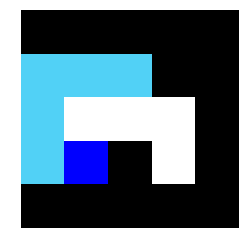

In [12]:
image = Prueba1()
start = (1,3)
goal = (2,1)
path = A_Star(start, goal, image)
#print path
#Plot(image)
Draw_Path(image, path[1:])
#Path_Simulator(image, path)

In [ ]:
image = mainproblem()
#Plot(image)
start, rr = Robot_Gravity_Center(image)
goal, rg = Goal_Gravity_Center(image)
path = A_Star(start, goal, image)
Draw_Path(image, path[1:])
#Path_Simulator(image, path)

# Algoritmo de búsqueda A*

# Reconstruye en camino de la lista cerrada
def reconstruct_path(closedset, current):
    path = [current['Node']]
    dt = np.dtype([('Node', tuple), ('Father', tuple), ('gScore', int), ('fScore', int)])
    recarray = np.array(closedset, dtype=dt)
    if closedset:
        api = recarray[list(recarray['Node']).index(current['Father'])] #
        while api['Node'] != api['Father']:
            path.append(api['Node'])
            api = recarray[list(recarray['Node']).index(api['Father'])]
    path.append(api['Node'])
    return path[::-1]

def A_Star(start, goal, image):  
    openset = []
    closedset = []
    openset.append( (start, start, 0, heuristic_cost_estimate(start, goal)) )
    dt = np.dtype([('Node', tuple), ('Father', tuple), ('gScore', int), ('fScore', int)])
    diag = set(((-1,-1),(-1,1),(1,-1),(1,1)))
    neighborhood = Neighbors()
    while openset:
        current = np.sort(np.array(openset, dtype=dt), order='fScore')[0]
        if (current['Node'] == goal):
            return reconstruct_path(closedset, current)
        #
        openset.remove(tuple(current))
        closedset.append(tuple(current))
        #
        (cx, cy) = current['Node']
        for (x,y) in neighborhood:
            if Image_Range((cx+x,cy+y), image.shape):
                if not Solid((cx+x,cy+y), image):
                    if (cx+x, cy+y) in set((np.array(closedset, dtype=dt)['Node'])):
                        continue
                    dist_bet = 14 if ((x,y) in diag) else 10
                    tentative_gScore = current['gScore'] + dist_bet
                    if (cx+x, cy+y) not in set((np.array(openset, dtype=dt)['Node'])): 
                        #Add
                        if Diagonal_Move((cx, cy), (x, y), image):
                            d = ((cx+x, cy+y), current['Node'], tentative_gScore,
                                tentative_gScore + heuristic_cost_estimate((cx+x, cy+y), goal))
                            openset.append(d)
                        continue
                    else:
                        if (tentative_gScore >= current['gScore']):
                            continue
                    openset.remove(openset[openset.index((cx+x, cy+y))])
                    d = (((cx+x, cy+y), current['Node'], tentative_gScore, 
                          tentative_gScore + heuristic_cost_estimate((cx+x, cy+y), goal)))
                    openset.append(d)

In [ ]:
# Algoritmo de búsqueda A* con Pandas (Lento pero una version entendible)
# Reconstruye en camino de la lista cerrada

import pandas as pd
def reconstruct_path(lsc, current):
    path = [current['Node']]
    if not lsc.empty:
        ID = lsc[lsc.Node==current['Father']].index[0]
        api = lsc.loc[ID]
        while api['Node'] != api['Father']:
            path.append(api['Node'])
            ID = lsc[lsc.Node==api['Father']].index[0]
            api = lsc.loc[ID]
    return path[::-1]

def A_Star(start, goal, image):  
    lsa = pd.DataFrame(columns=['Node', 'Father', 'gScore', 'fScore']) # Lista Abierta
    lsc = pd.DataFrame(columns=['Node', 'Father', 'gScore', 'fScore']) # Lista Cerrada
    d = {'Node':start, 'Father':start, 'gScore':0, 'fScore':heuristic_cost_estimate(start, goal) }
    lsa = lsa.append(d,ignore_index=True, sort=False)
    while not lsa.empty:
        ID = lsa.sort_values(by=["fScore"], ascending=True).index[0]
        current = lsa.loc[ID]
        if (current['Node'] == goal):
            return reconstruct_path(lsc, current)
        #
        lsa.drop([ID], inplace=True)
        lsc = lsc.append(current, ignore_index=True, sort=False)
        #
        diag = set(((-1,-1),(-1,1),(1,-1),(1,1)))
        (cx, cy) = current['Node']
        for (x,y) in Neighbors():
            if Image_Range((cx+x,cy+y), image.shape):
                if not Solid((cx+x,cy+y), image):
                    if (cx+x, cy+y) in list(lsc.Node):
                        continue
                    dist_bet = 14 if ((x,y) in diag) else 10
                    tentative_gScore = current['gScore'] + dist_bet
                    if (cx+x, cy+y) not in list(lsa.Node):
                        #Add
                        if Diagonal_Move((cx, cy), (x, y), image):
                            d = {'Node':(cx+x, cy+y), 'Father':current['Node'], 'gScore':tentative_gScore,
                                'fScore':tentative_gScore + heuristic_cost_estimate((cx+x, cy+y), goal) }
                            lsa = lsa.append(d,ignore_index=True, sort=False)
                        continue
                    else:
                        if (tentative_gScore >= current['gScore']):
                            continue
                    ID = lsa[lsa.Node==(cx+x, cy+y)].index[0]
                    lsa.loc[ID]['Father'] = current['Node']
                    lsa.loc[ID]['gScore'] = tentative_gScore
                    lsa.loc[ID]['fScore'] = tentative_gScore + heuristic_cost_estimate((cx+x, cy+y), goal)

# Funciones que cargan imagenes para realizar pruebas

In [23]:
# Métodos para realizar Pruebas
def Prueba1():
    image = np.zeros((5,5,3), np.uint8)
    #(x, y)
    cv2.rectangle(image, (1,3), (1,3), blue, -1) # Nodo Inicial
    cv2.rectangle(image, (2,1), (2,1), red, -1) # Nodo Final 
    cv2.rectangle(image, (1,2), (3,2), white, -1) # Nodos Sólidos
    cv2.rectangle(image, (3,3), (3,3), white, -1)
    return image
def Prueba2():
    image = np.zeros((17,25,3), np.uint8)
    cv2.rectangle(image, (3,7), (3,7), green, -1) # Nodo Inicial
    cv2.rectangle(image, (16,7), (16,7), red, -1) # Nodo Final 
    cv2.rectangle(image, (11,3), (11,11), white, -1) # Nodos Sólidos
    return image
def Prueba3():
    image = np.zeros((150,150,3), np.uint8)
    cv2.rectangle(image, (20,25), (20,25), green, -1) # Nodo Inicial
    cv2.rectangle(image, (100,124), (100,124), red, -1) # Nodo Final 
    cv2.rectangle(image, (40,12), (80,136), white, -1) # Nodos Sólidos

    return image
def Pruebacentro():
    image = np.zeros((60,80,3), np.uint8)
    imc = image.copy()
    #ubicación del robot
    [x,y] = [40, 15]
    pts = np.array( [[x,y], [x-25,y+25], [x+25,y+25]], np.int32)
    ((cx, cy), radius) = Gravity_Center(pts)
    pts = pts.reshape((-1,1,2))
    cv2.circle(imc, (cx, cy), radius, (15,150,0), -1) 
    cv2.fillPoly(image, [pts], (0,0,255))
    cv2.rectangle(image, (cx, cy), (cx, cy), (0,255,0), -1)
    return image, imc

[(20, 25), (20, 26), (20, 27), (20, 28), (20, 29), (20, 30), (20, 31), (20, 32), (20, 33), (20, 34), (20, 35), (20, 36), (20, 37), (20, 38), (20, 39), (20, 40), (20, 41), (20, 42), (20, 43), (20, 44), (20, 45), (20, 46), (20, 47), (20, 48), (20, 49), (20, 50), (20, 51), (20, 52), (20, 53), (20, 54), (20, 55), (20, 56), (20, 57), (20, 58), (20, 59), (20, 60), (20, 61), (20, 62), (20, 63), (20, 64), (20, 65), (20, 66), (20, 67), (20, 68), (20, 69), (20, 70), (20, 71), (20, 72), (20, 73), (20, 74), (20, 75), (20, 76), (20, 77), (20, 78), (20, 79), (20, 80), (20, 81), (20, 82), (20, 83), (20, 84), (20, 85), (20, 86), (20, 87), (20, 88), (20, 89), (20, 90), (20, 91), (20, 92), (20, 93), (20, 94), (20, 95), (20, 96), (20, 97), (20, 98), (20, 99), (20, 100), (20, 101), (20, 102), (20, 103), (20, 104), (20, 105), (20, 106), (20, 107), (20, 108), (20, 109), (20, 110), (20, 111), (20, 112), (20, 113), (20, 114), (20, 115), (20, 116), (20, 117), (20, 118), (21, 119), (22, 120), (23, 121), (24, 12

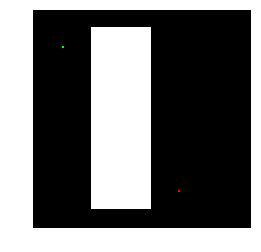

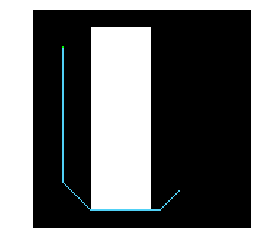

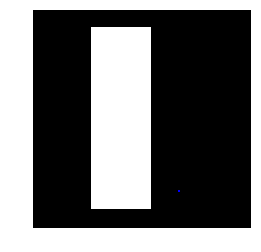

In [27]:
image = Prueba3()
start = (20,25)
goal = (100,124)
path = A_Star(start, goal, image)
print path
Plot(image)
Draw_Path(image, path[1:])
Path_Simulator(image, path)

[(3, 7), (4, 7), (5, 7), (6, 8), (7, 9), (8, 10), (9, 11), (10, 12), (11, 12), (12, 12), (12, 11), (13, 10), (14, 9), (15, 8), (16, 7)]


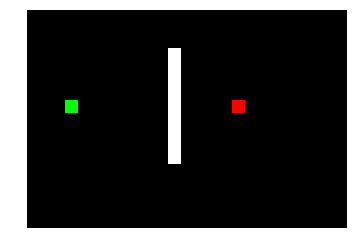

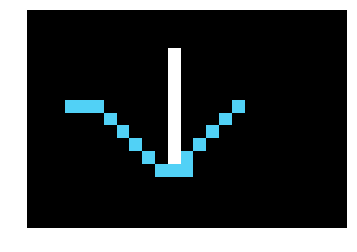

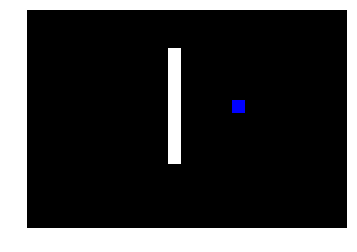

In [28]:
image = Prueba2()
start = (3,7)
goal = (16,7)
path = A_Star(start, goal, image)
print path
Plot(image)
Draw_Path(image, path)
Path_Simulator(image, path)

<IPython.core.display.Javascript object>


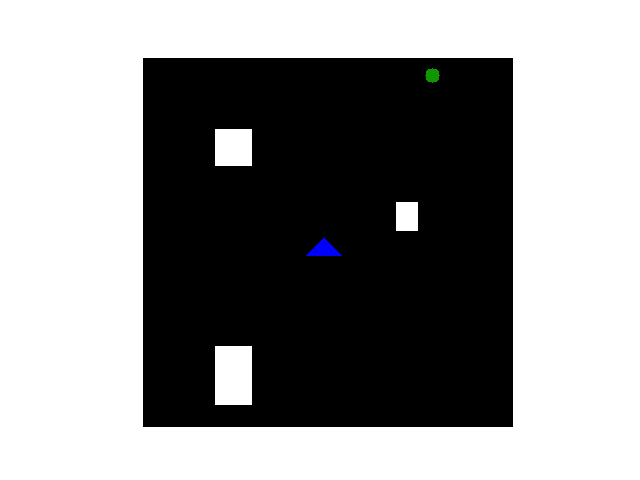

In [58]:
image = mainproblem()
start = (3,7)
goal = (16,7)
#path = A_Star(start, goal, image)
#print path
Plot(image)
#Draw_Path(image, path)
#Path_Simulator(image, path)

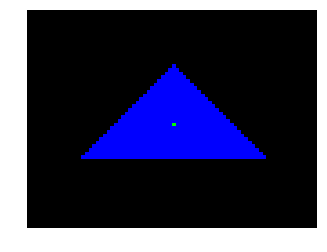

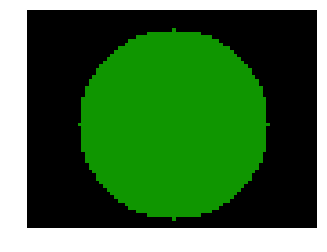

In [58]:
image, imc = Pruebacentro()
Plot(image)
Plot(imc)

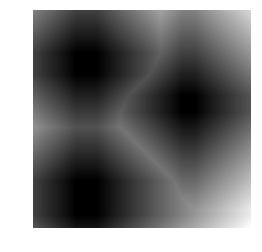

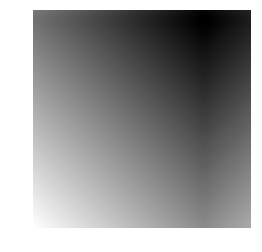

In [113]:
image = mainproblem()
dt1 = Distance_Transform(image)
dt2 = Distance_Transform(image, solids=False)
Plot(dt1)
Plot(dt2)

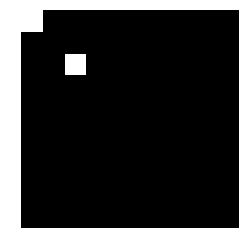

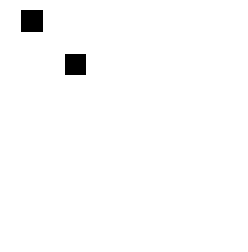

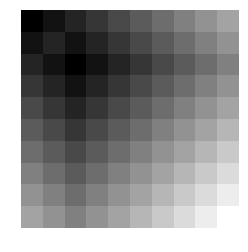

In [151]:
im = np.zeros((10,10), np.uint8)
im[0][0]=255
im[2][2]=255
retval, obs = cv2.threshold(im, 0, 255, cv2.THRESH_BINARY_INV)
dt = cv2.distanceTransform(obs, cv2.DIST_LABEL_PIXEL, 3)
Plot(im)
Plot(obs)
Plot(dt)

2.0


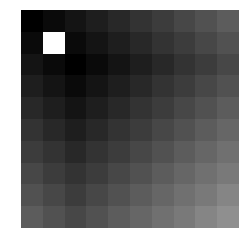

In [152]:
i=1
j=1
sample = dt.copy()
sample[i][j] = 25
print dt[i][j]
Plot(sample)

In [162]:
((cx, cy), r) = Robot_Gravity_Center(image)
print r

26


In [191]:
print dt[i][j+10]==r

True


36.0


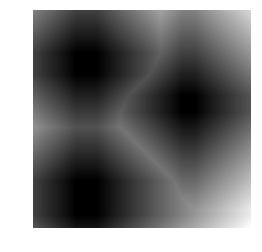

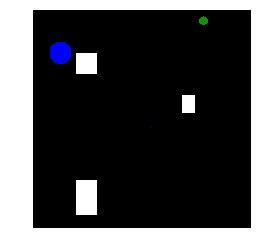

In [189]:
#im = Detect_Solids(image)
#dt = Distance_Transform(image)
co = image.copy()
i = 100#-(r+10)
j = 100-(r+10)
#co[cy][cx]=black
cv2.circle(co, (cx-12,cy-12), r, black, -1)
cv2.circle(co, (cx,cy), r, black, -1)
cv2.circle(co, (j,i), r, blue, -1)
print dt[i][j]
Plot(dt)
Plot(co)

In [189]:
ls = []
for i in range(10):
    ls.append([(i,i*3+3), (0, i), i*10, i+2*+3*7])
recarray = np.array(ls)
recarray[4] = [(2,3),(8,9), 100, 35]

print ls
ID = list(np.array(ls)[:,0]).index((2,9))
ls[ID] = [(1,2),(100,100),2,3]
print ls

[[(0, 3), (0, 0), 0, 42], [(1, 6), (0, 1), 10, 43], [(2, 9), (0, 2), 20, 44], [(3, 12), (0, 3), 30, 45], [(4, 15), (0, 4), 40, 46], [(5, 18), (0, 5), 50, 47], [(6, 21), (0, 6), 60, 48], [(7, 24), (0, 7), 70, 49], [(8, 27), (0, 8), 80, 50], [(9, 30), (0, 9), 90, 51]]
[[(0, 3), (0, 0), 0, 42], [(1, 6), (0, 1), 10, 43], [(1, 2), (100, 100), 2, 3], [(3, 12), (0, 3), 30, 45], [(4, 15), (0, 4), 40, 46], [(5, 18), (0, 5), 50, 47], [(6, 21), (0, 6), 60, 48], [(7, 24), (0, 7), 70, 49], [(8, 27), (0, 8), 80, 50], [(9, 30), (0, 9), 90, 51]]


In [221]:
x = np.array([('Rex', 9, 81.0), ('Fido', 3, 27.0)], dtype=[('name', 'U10'), ('age', 'i4'), ('weight', 'f4')])

In [222]:
x

array([(u'Rex', 9, 81.), (u'Fido', 3, 27.)],
      dtype=[('name', '<U10'), ('age', '<i4'), ('weight', '<f4')])